- CNN pour la clacification du dataset avec les 10 catégorie https://keras.io/api/datasets/cifar10/
#- Fine tuning de mobilenet (ajout d'un dense layer pour catégorisation)

## Step 0: Mac M2 GPU

- The Neural Engine is primarily used for inference through Core ML
- TensorFlow training uses the GPU cores via Metal Performance Shaders (MPS)
- As of 2024, use Python 3.11 with TensorFlow 2.15.1 and tensorflow-metal 1.1.0 for best compatibility

In [1]:
%pip install tensorflow-metal
%pip install tensorflow-macos

# Step 1: System Information and TensorFlow Configuration
import sys
import platform
import subprocess
import tensorflow as tf

print("="*80)
print(" "*25 + "SYSTEM INFORMATION")
print("="*80)

# System details
print(f"\n📱 Platform: {platform.platform()}")
print(f"🏗️ Architecture: {platform.machine()}")
print(f"🐍 Python Version: {sys.version}")
print(f"📦 TensorFlow Version: {tf.__version__}")

# Check for tensorflow-metal
try:
    import tensorflow_metal
    print(f"TensorFlow Metal: Installed")
except ImportError:
    print("TensorFlow Metal: Not installed - GPU acceleration unavailable!")
    print("   Install with: pip install tensorflow-metal")

# Check macOS version
try:
    macos_version = subprocess.check_output(['sw_vers', '-productVersion']).decode().strip()
    print(f"macOS Version: {macos_version}")
    
    # Verify minimum version (12.0 required for Metal)
    major, minor = map(int, macos_version.split('.')[:2])
    if major < 12:
        print("WARNING: macOS 12.0+ required for Metal GPU support!")
except:
    pass

print("\n" + "="*80)
print(" "*25 + "GPU DETECTION & VERIFICATION")
print("="*80)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                         SYSTEM INFORMATION

📱 Platform: macOS-15.6.1-arm64-arm-64bit
🏗️ Architecture: arm64
🐍 Python Version: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
📦 TensorFlow Version: 2.16.2
TensorFlow Metal: Not installed - GPU acceleration unavailable!
   Install with: pip install tensorflow-metal
macOS Version: 15.6.1

                         GPU DETECTION & VERIFICATION


In [2]:
# Step 2: GPU Detection and Configuration
print("\n Detecting available devices...")

# List all physical devices
devices = tf.config.list_physical_devices()
print(f"\nAll devices found: {len(devices)}")
for device in devices:
    print(f"   - {device}")

# Check specifically for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU DETECTED! Found {len(gpus)} GPU device(s)")
    for i, gpu in enumerate(gpus):
        print(f"\nGPU {i} Details:")
        print(f"   Device: {gpu}")
        try:
            details = tf.config.experimental.get_device_details(gpu)
            for key, value in details.items():
                print(f"   {key}: {value}")
        except:
            print(" (Unable to get detailed GPU information)")
    
    # Configure GPU memory growth
    print("\n Configuring GPU memory growth...")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" Memory growth enabled - GPU will allocate memory as needed")
    except RuntimeError as e:
        print(f" Could not set memory growth: {e}")
        
else:
    print("\n NO GPU DETECTED!")
    print("   Possible reasons:")
    print("   1. tensorflow-metal not installed")
    print("   2. Incompatible TensorFlow version")
    print("   3. System doesn't have compatible GPU")
    print("\n   To install tensorflow-metal:")
    print("   pip install tensorflow-metal==1.1.0")

# Enable device placement logging
print("\n📍 Enabling device placement logging...")
tf.debugging.set_log_device_placement(False)


 Detecting available devices...

All devices found: 2
   - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU DETECTED! Found 1 GPU device(s)

GPU 0 Details:
   Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   device_name: METAL

 Configuring GPU memory growth...
 Memory growth enabled - GPU will allocate memory as needed

📍 Enabling device placement logging...


# Step 1: Initialisation

In [3]:
# MINIMAL REQUIREMENTS 

# Python 
import sys
assert sys.version_info >= (3,11)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# COLAB DETECTION 

try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TENSORFLOW
import tensorflow as tf
assert tf.__version__ >= "2.16"
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

# COMMON IMPORTS
import numpy as np
import os
from datetime import datetime
import json


# REPRODUCTIBILITY
np.random.seed(42)
tf.random.set_seed(42)

# MATPLOTLIB CONFIGURATION
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# PREPARE FOLDERS FOR FIGURES 
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cifar10_cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

def save_fig(fig_id: str, tight_layout: bool = True, fig_extension: str = "png", resolution: int = 300):

    filename = f"{fig_id}_{timestamp}.{fig_extension}"
    path = os.path.join(IMAGES_PATH, filename)
    print("Saving figure", filename)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



# Step 2: "Down"-load and check cifar10 dataset

In [4]:
# Load the cifar10 dataset from keras build-in datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [5]:
# Check the dataset is corretly load by using .shape on each set (Training and Test)
print(f"x_train shape: {x_train.shape} -> expected ('50,000','32'.'32'.'3')")
print(f"x_test shape: {x_test.shape} -> expected ('10,000','32'.'32'.'3')")
print(f"y_train shape: {y_train.shape} -> expected ('50,000','1')")
print(f"y_test shape: {y_test.shape} -> expected ('10,000','1')")

x_train shape: (50000, 32, 32, 3) -> expected ('50,000','32'.'32'.'3')
x_test shape: (10000, 32, 32, 3) -> expected ('10,000','32'.'32'.'3')
y_train shape: (50000, 1) -> expected ('50,000','1')
y_test shape: (10000, 1) -> expected ('10,000','1')


CIFAR-10 contains:
- 50,000 training images and 10,000 test images
- Each image is 32×32 pixels with 3 color channels (RGB)
- Labels are stored as single integers (0-9) in shape (n, 1)

# Step 3: Normalizing pixel values

In [6]:
# NN like 0 and 1 so scales 0-250 to 0-1 store as float32
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Run some checks
print(f"Min value: {x_train.min()} -> expected (0.0)")
print(f"Max value: {x_train.max()} -> expected (1.0)")
print(f"Data type: {x_train.dtype} -> expected (float32)")

Min value: 0.0 -> expected (0.0)
Max value: 1.0 -> expected (1.0)
Data type: float32 -> expected (float32)


# Step 4: Define Labels name

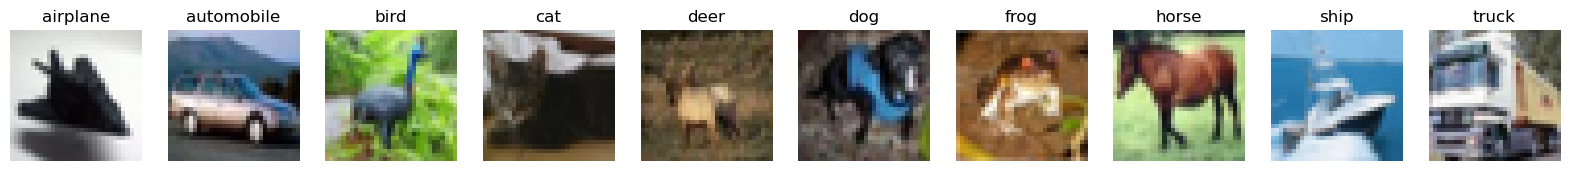

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Show all 10 classes once each
plt.figure(figsize=(20, 2))
for i in range(len(class_names)):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[idx])
    plt.title(f"{class_names[i]}")
    plt.axis('off')
plt.show()

# Step 5: Shape and display the model

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),

    # CONV -> Batch -> CONV -> Batch -> Pooling 
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # CONV -> Batch -> CONV -> Batch -> Pooling 
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # CONV -> Batch -> CONV -> Batch -> Pooling 
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(), 
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)), 
    #Flatten -> Drop -> FullConnected -> Drop -> FullConnected -> Softmax
    layers.Flatten(),
    layers.Dropout(0.2),  
    layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),

    # CONV -> Batch -> CONV -> Batch -> Drop -> Pooling 
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2), 
    layers.MaxPooling2D((2, 2)),
    # CONV -> Batch -> DEPTHCONV-> -> Batch -> CONV -> Batch -> Drop -> Pooling 
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same', depthwise_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3), 
    layers.MaxPooling2D((2, 2)),
    # CONV -> Batch -> CONV -> Batch -> Drop -> Pooling 
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(), 
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.4), 
    layers.MaxPooling2D((2, 2)), 
    # GAP -> Drop -> Softmax
    layers.GlobalAveragePooling2D(),  # Reduces parameters dramatically
    layers.Dropout(0.5),              # Higher dropout before final layer
    layers.Dense(10, activation='softmax')
])

From this paper https://arxiv.org/pdf/2102.11506

'''
Why remove DepthwiseConv2D?

The paper shows simpler architectures often perform better
For CIFAR-10's 32x32 images, regular Conv2D is more suitable
Reduces computational overhead.

Why reduce dropout rates?

The model might be over-regularized
Combined with augmentation, high dropout can hurt learning speed

Why add the extra Conv2D block?

Follows the paper's insight about regional feature extraction
256 filters can capture more complex patterns before classification



model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),  
    layers.MaxPooling2D((2, 2)),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  
    layers.MaxPooling2D((2, 2)),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  
    layers.MaxPooling2D((2, 2)),
    
    # Block 4: Enhanced feature extraction
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

'''

In [8]:
# From : https://gist.githubusercontent.com/koshian2/3d99ff54715de586f3ac050b32fa1402/raw/9d0ef7ae38be40290463302362dcbeea02e502a7/CIFAR10_10Layers.py


model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    
    # Block 1: Light start with multi-scale hint
    layers.Conv2D(32, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),  
    #layers.MaxPooling2D((2, 2)),
    
    # Block 2: Multi-scale feature extraction
    layers.Conv2D(64, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),  
    #layers.MaxPooling2D((2, 2)),
    
    # Block 3: Enhanced multi-scale with larger receptive field
    layers.Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    # Add dilated convolution instead of 5x5 for efficiency
    layers.Conv2D(128, (3, 3), dilation_rate=2, activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  
    #layers.MaxPooling2D((2, 2)),

    # Block 4: Enhanced multi-scale with larger receptive field
    layers.Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),  
    layers.MaxPooling2D((2, 2)),
    
    # Block 5: Final feature extraction - simplified but powerful
    layers.Conv2D(512, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

2025-09-08 15:45:57.399285: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-09-08 15:45:57.399326: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-09-08 15:45:57.399348: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-09-08 15:45:57.399391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-08 15:45:57.399410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Step 5.1: Define some hyperparameters

In [9]:
BATCH_SIZE = 64
EPOCHS = 100
LR_ADAM = 0.001
NUM_AUGMENTATIONS = 10

# Step 5.2 Define callback functions

In [10]:

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Separate folders for each phase
base_log_dir = "logs/fit/"

log_dir_phase1 = f"{base_log_dir}train_{timestamp}/phase1"
log_dir_phase2 = f"{base_log_dir}train_{timestamp}/phase2"
log_dir_phase3 = f"{base_log_dir}train_{timestamp}/phase3"


os.makedirs(log_dir_phase1, exist_ok=True)
os.makedirs(log_dir_phase2, exist_ok=True)
os.makedirs(log_dir_phase3, exist_ok=True)

callbacks = [
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',       
        mode='min',
        factor=0.5, # Reduce LR by 50% (multiply by 0.5)
        patience=3, # Wait 3 epochs before reducing
        min_lr=1e-7, # Don't go below this LR
        verbose=1 # Print when LR changes
    ),
    
    # Stop training if no improvement
    EarlyStopping(
        monitor='val_loss',
        patience=5,          # ← Reduced from 10
        min_delta=0.01,      # ← Require bigger improvements
        restore_best_weights=True,
        verbose=1
    ),
    # To save data during run
    TensorBoard(
        log_dir=log_dir_phase1, 
        histogram_freq=1,
        write_graph=False,  # Disable graph writing to avoid GraphDef issues
        update_freq='epoch',  # Log metrics after each epoch
        profile_batch=0,  # Disable profiling to avoid conflicts
        embeddings_freq=0  # Disable embeddings logging
    )
]



# Step 6: Compile and show the model

In [11]:

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR_ADAM, clipnorm=1.0, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# View the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 256)    │         1,02

 Total params: 3,479,978 (13.28 MB)

 Trainable params: 3,475,754 (13.26 MB)

 Non-trainable params: 4,224 (16.50 KB)

# Step 7: Train the model

In [ ]:
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-09-08 15:45:59.681971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


253/782 ━━━━━━━━━━━━━━━━━━━━ 3:01 343ms/step - accuracy: 0.3006 - loss: 1.9797

Saving figure phase1_training_history_20250831-230808.png


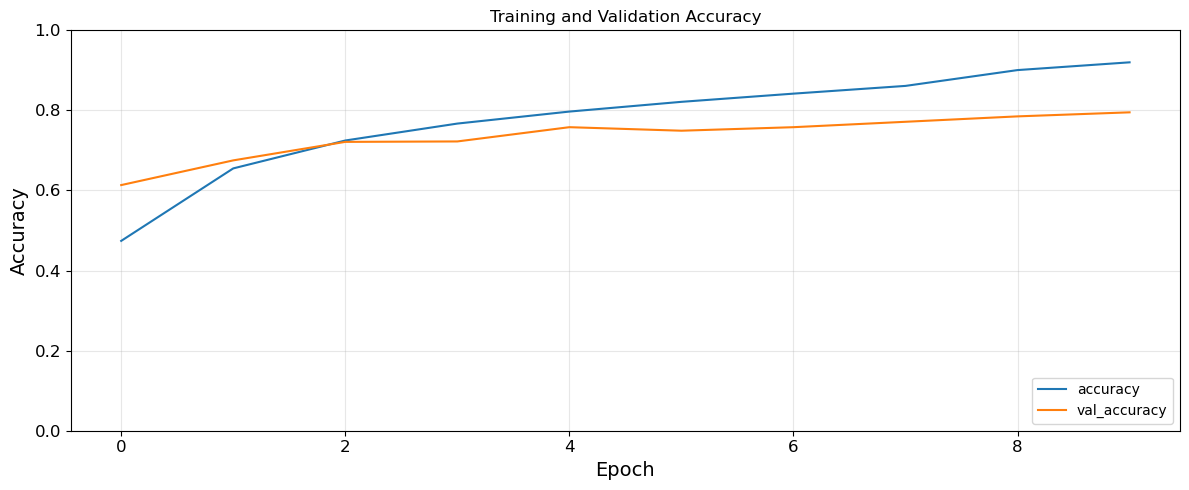

313/313 - 3s - 11ms/step - accuracy: 0.7581 - loss: 0.7188

Test accuracy: 0.7581
Test loss: 0.7188


In [ ]:
 # Create subplots for accuracy and loss
fig, ax1 = plt.subplots(1,1, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.0, 1])
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')
ax1.grid(True, alpha=0.3)

save_fig("phase1_training_history")

plt.tight_layout()
plt.show()


# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Step 7.1: Save model and final results

In [ ]:
import json


# Create Phase 1 file writer
file_writer_phase1 = tf.summary.create_file_writer(log_dir_phase1)
with file_writer_phase1.as_default():
    # Get actual training info
    actual_epochs = len(history.history['loss'])
    final_lr = model.optimizer.learning_rate.numpy()

    # 1. Model architecture
    img_path = f'{log_dir_phase1}/model_architecture.png'
    plot_model(model, to_file=img_path, show_shapes=True, show_layer_names=True)
    image = tf.keras.preprocessing.image.load_img(img_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    tf.summary.image("Model Architecture", [image], step=0)

    # 2. Extract data augmentation parameters
    aug_params = {}
    if len(model.layers) > 1 and hasattr(model.layers[1], 'layers'):
        for i, layer in enumerate(model.layers[1].layers):
            layer_name = f"{layer.__class__.__name__}_{i}"
            if hasattr(layer, 'factor'):
                aug_params[f"{layer_name}_factor"] = float(layer.factor)
            if hasattr(layer, 'height_factor'):
                aug_params[f"{layer_name}_height_factor"] = float(layer.height_factor)
            if hasattr(layer, 'width_factor'):
                aug_params[f"{layer_name}_width_factor"] = float(layer.width_factor)
            if hasattr(layer, 'mode'):
                aug_params[f"{layer_name}_mode"] = str(layer.mode)
            aug_params[f"{layer_name}_type"] = layer.__class__.__name__

    # 3. Calculate performance metrics
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    best_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    best_loss_epoch = history.history['val_loss'].index(best_val_loss) + 1

    # 4. Build augmentation section
    aug_section = ""
    if aug_params:
        aug_lines = [f"    - {k}: {v}" for k, v in aug_params.items()]
        aug_section = f"""
    
    **Data Augmentation:**
{chr(10).join(aug_lines)}"""

    # 5. Get initial learning rate dynamically
    try:
        optimizer_config = model.optimizer.get_config()
        initial_lr = optimizer_config.get('learning_rate', 'Unknown')
    except:
        initial_lr = 'Unknown'
    
    # 6. Build callbacks information (FIX: Create callbacks_section)
    callbacks_info = []
    for callback in callbacks:
        if isinstance(callback, tf.keras.callbacks.ReduceLROnPlateau):
            callbacks_info.append(f"    - ReduceLROnPlateau (monitor='{callback.monitor}', factor={callback.factor}, patience={callback.patience}, min_lr={callback.min_lr})")
        elif isinstance(callback, tf.keras.callbacks.EarlyStopping):
            callbacks_info.append(f"    - EarlyStopping (monitor='{callback.monitor}', patience={callback.patience}, restore_best_weights={callback.restore_best_weights})")
        elif isinstance(callback, tf.keras.callbacks.TensorBoard):
            callbacks_info.append(f"    - TensorBoard (log_dir='{callback.log_dir}', histogram_freq={callback.histogram_freq})")
        else:
            callbacks_info.append(f"    - {callback.__class__.__name__}")
    
    # FIX: Convert callbacks_info list to callbacks_section string
    callbacks_section = '\n'.join(callbacks_info) if callbacks_info else "    - No callbacks configured"
    
    # 7. Get batch size and epochs from variables
    batch_size = BATCH_SIZE
    planned_epochs = EPOCHS

    # 8. Build training summary
    training_summary = f"""
    **PHASE 1: Training Configuration & Results**
    
    **Model Architecture:**
    - Total Parameters: {model.count_params():,}
    - Total Layers: {len(model.layers)}
    - Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}
    
    **Optimizer:** {model.optimizer.__class__.__name__}
    - Initial Learning Rate: {initial_lr}
    - Final Learning Rate: {final_lr:.2e}
    - Clipnorm: {model.optimizer.clipnorm}
    
    **Loss:** {model.loss}
    **Metrics:** {[m.name for m in model.metrics]}{aug_section}
    
    **Training Details:**
    - Planned Epochs: {planned_epochs}
    - Actual Epochs Run: {actual_epochs}
    - Batch Size: {batch_size}
    - Training Samples: {len(x_train):,}
    - Validation Samples: {len(x_test):,}
    - Steps per Epoch: {len(x_train) // batch_size}
    
    **Final Performance (Epoch {actual_epochs}):**
    - Train Accuracy: {history.history['accuracy'][-1]:.4f}
    - Train Loss: {history.history['loss'][-1]:.4f}
    - Val Accuracy: {history.history['val_accuracy'][-1]:.4f}
    - Val Loss: {history.history['val_loss'][-1]:.4f}
    
    **Best Performance:**
    - Best Val Accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})
    - Best Val Loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})
    
    **Callbacks Used:**
{callbacks_section}
    
    **Training Time:** {timestamp}
    **Log Directory:** {log_dir_phase1}
    """
    tf.summary.text("Complete Training Report", training_summary, step=0)

    # 9. Log key metrics as scalars
    tf.summary.scalar('phase1_results/planned_epochs', planned_epochs, step=0)
    tf.summary.scalar('phase1_results/epochs_trained', actual_epochs, step=0)
    tf.summary.scalar('phase1_results/batch_size', batch_size, step=0)
    tf.summary.scalar('phase1_results/best_val_accuracy', best_val_acc, step=0)
    tf.summary.scalar('phase1_results/best_val_loss', best_val_loss, step=0)
    tf.summary.scalar('phase1_results/final_val_accuracy', history.history['val_accuracy'][-1], step=0)
    tf.summary.scalar('phase1_results/final_learning_rate', final_lr, step=0)
    tf.summary.scalar('phase1_results/total_parameters', model.count_params(), step=0)

    # 10. Log augmentation parameters as scalars
    for param, value in aug_params.items():
        if isinstance(value, (int, float)):
            tf.summary.scalar(f'phase1_augmentation/{param}', value, step=0)

    # 11. Model summary
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    model_summary = "\n".join(stringlist)
    tf.summary.text("Model Architecture Details", model_summary, step=0)

    # 12. Training history graph data
    import json  # Ensure json is available
    history_json = json.dumps(history.history, indent=2)
    tf.summary.text("Training History JSON", f"```json\n{history_json}\n```", step=0)

    # 13. Log augmentation parameters as text
    if aug_params:
        tf.summary.text("Data Augmentation Parameters", json.dumps(aug_params, indent=2), step=0)

    # Flush summaries
    file_writer_phase1.flush()

# =============================================================================
# PHASE 1: Model and Data Saving
# =============================================================================

print("Phase 1: Saving model and training artifacts...")

# Save model and weights
model_path = f'{log_dir_phase1}/phase1_model.keras'
weights_path = f'{log_dir_phase1}/phase1_weights.weights.h5'
history_path = f'{log_dir_phase1}/phase1_training_history.json'

model.save(model_path)
model.save_weights(weights_path)

# Save history
import json  # Ensure json is available for file saving
with open(history_path, 'w') as f:
    json.dump(history.history, f, indent=2)

# Save augmentation parameters
if aug_params:
    aug_path = f'{log_dir_phase1}/phase1_augmentation_params.json'
    with open(aug_path, 'w') as f:
        json.dump(aug_params, f, indent=2)
    print(f"✓ Augmentation parameters saved: {aug_path}")

# Create Phase 1 summary
summary_path = f'{log_dir_phase1}/phase1_summary.txt'
with open(summary_path, 'w') as f:
    f.write(f"""
=============================================================================
PHASE 1: TRAINING RESULTS SUMMARY
=============================================================================

Training Configuration:
- Batch Size: {batch_size}
- Planned Epochs: {planned_epochs}
- Actual Epochs: {actual_epochs}

Model Information:
- Total Parameters: {model.count_params():,}
- Total Layers: {len(model.layers)}

Performance Results:
- Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})
- Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}
- Best Validation Loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})
- Final Validation Loss: {history.history['val_loss'][-1]:.4f}

Files Created:
- Model: {model_path}
- Weights: {weights_path}  
- History: {history_path}
- Summary: {summary_path}

TensorBoard Command:
tensorboard --logdir {log_dir_phase1}

Generated: {timestamp}
=============================================================================
""")

print("\n" + "="*60)
print("PHASE 1: LOGGING COMPLETED SUCCESSFULLY")
print("="*60)
print(f"✓ Model saved: {model_path}")
print(f"✓ Weights saved: {weights_path}")
print(f"✓ Training history saved: {history_path}")
print(f"✓ Summary saved: {summary_path}")
print(f"✓ TensorBoard logs: {log_dir_phase1}")
print(f"\nBest validation accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})")
print(f"View in TensorBoard: tensorboard --logdir {log_dir_phase1}")
print("="*60)

Phase 1: Saving model and training artifacts...

PHASE 1: LOGGING COMPLETED SUCCESSFULLY
✓ Model saved: logs/fit/train_20250831-230808/phase1/phase1_model.keras
✓ Weights saved: logs/fit/train_20250831-230808/phase1/phase1_weights.weights.h5
✓ Training history saved: logs/fit/train_20250831-230808/phase1/phase1_training_history.json
✓ Summary saved: logs/fit/train_20250831-230808/phase1/phase1_summary.txt
✓ TensorBoard logs: logs/fit/train_20250831-230808/phase1

Best validation accuracy: 0.7952 (Epoch 10)
View in TensorBoard: tensorboard --logdir logs/fit/train_20250831-230808/phase1


In [ ]:
# Check label shape and values
print(f"y_train shape: {y_train.shape}")
print(f"y_train sample values: {y_train[:5]}")
print(f"y_train unique values: {np.unique(y_train)}")
print(f"x_train min: {x_train.min()}, max: {x_train.max()}")
print(f"x_test min: {x_test.min()}, max: {x_test.max()}")
print(f"x_train min: {x_train.min()}, max: {x_train.max()}")
print(f"x_test min: {x_test.min()}, max: {x_test.max()}")

y_train shape: (50000, 1)
y_train sample values: [[6]
 [9]
 [9]
 [4]
 [1]]
y_train unique values: [0 1 2 3 4 5 6 7 8 9]
x_train min: 0.0, max: 1.0
x_test min: 0.0, max: 1.0
x_train min: 0.0, max: 1.0
x_test min: 0.0, max: 1.0


# Step 8: Same but using data augmentation

In [ ]:
# From : https://gist.githubusercontent.com/koshian2/3d99ff54715de586f3ac050b32fa1402/raw/9d0ef7ae38be40290463302362dcbeea02e502a7/CIFAR10_10Layers.py


model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    
    # Block 1: Light start with multi-scale hint
    layers.Conv2D(32, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),  
    #layers.MaxPooling2D((2, 2)),
    
    # Block 2: Multi-scale feature extraction
    layers.Conv2D(64, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),  
    #layers.MaxPooling2D((2, 2)),
    
    # Block 3: Enhanced multi-scale with larger receptive field
    layers.Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    # Add dilated convolution instead of 5x5 for efficiency
    layers.Conv2D(128, (3, 3), dilation_rate=2, activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  
    #layers.MaxPooling2D((2, 2)),

    # Block 4: Enhanced multi-scale with larger receptive field
    layers.Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),  
    layers.MaxPooling2D((2, 2)),
    
    # Block 5: Final feature extraction - simplified but powerful
    layers.Conv2D(512, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [ ]:
callbacks = [
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',       
        mode='min',
        factor=0.5, 
        patience=3, 
        min_lr=1e-7, 
        verbose=1
    ),
    
    # Stop training if no improvement
    EarlyStopping(
        monitor='val_loss',
        patience=5,          # ← Reduced from 10
        min_delta=0.01,      # ← Require bigger improvements
        restore_best_weights=True,
        verbose=1
    ),
    
    # To save data during run
    TensorBoard(
        log_dir=log_dir_phase2, 
        histogram_freq=1,
        write_graph=False,  # Disable graph writing to avoid GraphDef issues
        update_freq='epoch',  # Log metrics after each epoch
        profile_batch=0,  # Disable profiling to avoid conflicts
        embeddings_freq=0  # Disable embeddings logging
    )
]



In [ ]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR_ADAM, clipnorm=1.0, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# View the architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,071,082 (15.53 MB)

 Trainable params: 4,066,346 (15.51 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [ ]:
# Load the cifar10 dataset from keras build-in datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# NN like 0 and 1 so scales 0-250 to 0-1 store as float32
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),   # Also vertical flip
    tf.keras.layers.RandomRotation(0.2),      # ±11.5 degrees
    tf.keras.layers.RandomZoom(0.2),          # ±20% zoom
    tf.keras.layers.RandomContrast(0.2),      # ±20% contrast
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomBrightness(0.15),   # Stronger brightness
    tf.keras.layers.RandomContrast(0.2),      # Stronger contrast
    tf.keras.layers.RandomSaturation(0.1), 
], name='augmentation')


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_dataset = train_dataset.batch(BATCH_SIZE)

# Create validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)


In [ ]:

# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-08-31 23:28:52.227301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 7820 of 10000
2025-08-31 23:28:54.750257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 183s 211ms/step - accuracy: 0.0990 - loss: 2.5335 - val_accuracy: 0.0839 - val_loss: 2.5915 - learning_rate: 0.0010
Epoch 2/100


2025-08-31 23:31:52.367048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 8623 of 10000
2025-08-31 23:31:53.976249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 173s 207ms/step - accuracy: 0.1013 - loss: 2.4314 - val_accuracy: 0.1222 - val_loss: 2.3466 - learning_rate: 0.0010
Epoch 3/100


2025-08-31 23:34:45.702114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 8518 of 10000
2025-08-31 23:34:47.395606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 175s 208ms/step - accuracy: 0.0994 - loss: 2.3836 - val_accuracy: 0.0979 - val_loss: 5.7499 - learning_rate: 0.0010
Epoch 4/100


2025-08-31 23:37:40.248676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 8547 of 10000
2025-08-31 23:37:41.935870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 174s 207ms/step - accuracy: 0.0991 - loss: 2.3516 - val_accuracy: 0.1149 - val_loss: 2.4924 - learning_rate: 0.0010
Epoch 5/100


2025-08-31 23:40:34.164836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 8623 of 10000
2025-08-31 23:40:35.733079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 181s 217ms/step - accuracy: 0.0984 - loss: 2.3297 - val_accuracy: 0.1028 - val_loss: 2.3079 - learning_rate: 0.0010
Epoch 6/100


2025-08-31 23:43:35.608593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 8089 of 10000
2025-08-31 23:43:37.952700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 189s 226ms/step - accuracy: 0.0981 - loss: 2.3269 - val_accuracy: 0.0898 - val_loss: 2.3396 - learning_rate: 0.0010
Epoch 7/100


2025-08-31 23:46:44.589870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 5486 of 10000
2025-08-31 23:46:52.525292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 188s 218ms/step - accuracy: 0.1006 - loss: 2.3256 - val_accuracy: 0.1052 - val_loss: 2.3277 - learning_rate: 0.0010
Epoch 8/100


2025-08-31 23:49:53.025949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 5546 of 10000
2025-08-31 23:50:00.948216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.1018 - loss: 2.3240
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 ━━━━━━━━━━━━━━━━━━━━ 190s 220ms/step - accuracy: 0.1006 - loss: 2.3241 - val_accuracy: 0.0908 - val_loss: 2.3215 - learning_rate: 0.0010
Epoch 9/100


2025-08-31 23:53:03.051501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 6700 of 10000
2025-08-31 23:53:08.305170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 187s 219ms/step - accuracy: 0.0997 - loss: 2.3182 - val_accuracy: 0.0872 - val_loss: 2.3135 - learning_rate: 5.0000e-04
Epoch 10/100


2025-08-31 23:56:09.730172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 8227 of 10000
2025-08-31 23:56:12.167349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 180s 214ms/step - accuracy: 0.0997 - loss: 2.3145 - val_accuracy: 0.0672 - val_loss: 2.3198 - learning_rate: 5.0000e-04
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


Saving figure phase2_training_history_20250831-230808.png


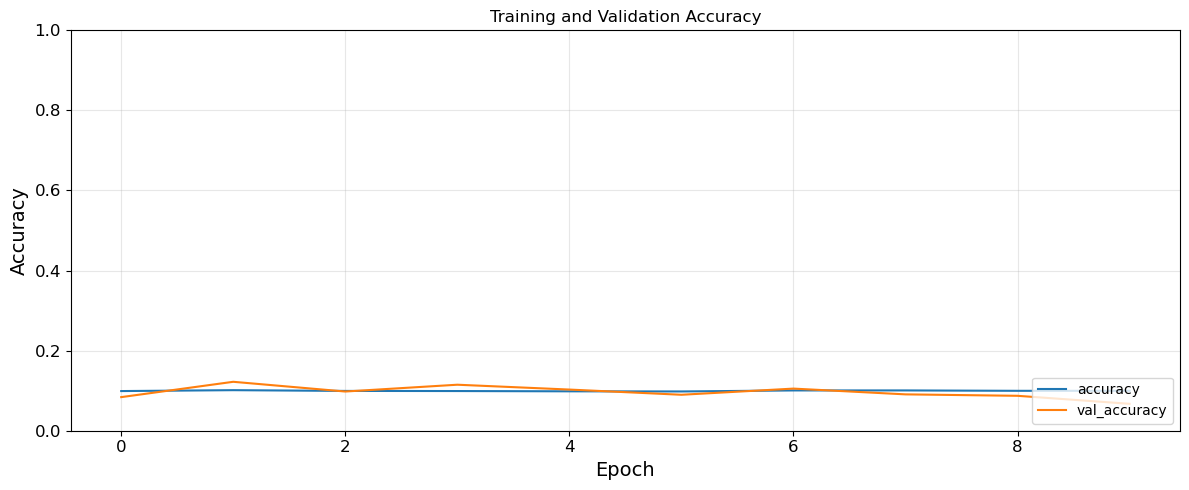

313/313 - 4s - 12ms/step - accuracy: 0.1028 - loss: 2.3079

Test accuracy: 0.1028
Test loss: 2.3079


In [ ]:
 # Create subplots for accuracy and loss
fig, ax1 = plt.subplots(1,1, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.0, 1])
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')
ax1.grid(True, alpha=0.3)

save_fig("phase2_training_history")

plt.tight_layout()
plt.show()


# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Step 8.1 Save model and final results

In [ ]:
# Create Phase 2 file writer
file_writer_phase2 = tf.summary.create_file_writer(log_dir_phase2)
with file_writer_phase2.as_default():
    # Get actual training info
    actual_epochs = len(history.history['loss'])
    final_lr = model.optimizer.learning_rate.numpy()

    # 1. Model architecture
    img_path = f'{log_dir_phase2}/model_architecture.png'
    plot_model(model, to_file=img_path, show_shapes=True, show_layer_names=True)
    image = tf.keras.preprocessing.image.load_img(img_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    tf.summary.image("Model Architecture", [image], step=0)

    # 2. Extract data augmentation parameters (with proper type handling)
    aug_params = {}
    if len(model.layers) > 1 and hasattr(model.layers[1], 'layers'):
        for i, layer in enumerate(model.layers[1].layers):
            layer_name = f"{layer.__class__.__name__}_{i}"
            
            # Handle factor (can be float, int, tuple, or None)
            if hasattr(layer, 'factor'):
                factor = layer.factor
                if factor is None:
                    aug_params[f"{layer_name}_factor"] = None
                elif isinstance(factor, (tuple, list)):
                    aug_params[f"{layer_name}_factor"] = list(factor)  # Convert to list for JSON serialization
                else:
                    aug_params[f"{layer_name}_factor"] = float(factor)
            
            # Handle height_factor (can be float, int, tuple, or None)
            if hasattr(layer, 'height_factor'):
                height_factor = layer.height_factor
                if height_factor is None:
                    aug_params[f"{layer_name}_height_factor"] = None
                elif isinstance(height_factor, (tuple, list)):
                    aug_params[f"{layer_name}_height_factor"] = list(height_factor)
                else:
                    aug_params[f"{layer_name}_height_factor"] = float(height_factor)
            
            # Handle width_factor (can be float, int, tuple, or None)
            if hasattr(layer, 'width_factor'):
                width_factor = layer.width_factor
                if width_factor is None:
                    aug_params[f"{layer_name}_width_factor"] = None
                elif isinstance(width_factor, (tuple, list)):
                    aug_params[f"{layer_name}_width_factor"] = list(width_factor)
                else:
                    aug_params[f"{layer_name}_width_factor"] = float(width_factor)
            
            # Handle string attributes
            if hasattr(layer, 'mode'):
                aug_params[f"{layer_name}_mode"] = str(layer.mode) if layer.mode is not None else None
            if hasattr(layer, 'fill_mode'):
                aug_params[f"{layer_name}_fill_mode"] = str(layer.fill_mode) if layer.fill_mode is not None else None
            if hasattr(layer, 'interpolation'):
                aug_params[f"{layer_name}_interpolation"] = str(layer.interpolation) if layer.interpolation is not None else None
            
            # Handle seed (can be None)
            if hasattr(layer, 'seed'):
                aug_params[f"{layer_name}_seed"] = int(layer.seed) if layer.seed is not None else None
            
            # Always include layer type
            aug_params[f"{layer_name}_type"] = layer.__class__.__name__

    # 3. Calculate performance metrics
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    best_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    best_loss_epoch = history.history['val_loss'].index(best_val_loss) + 1

    # 4. Build augmentation section
    aug_section = ""
    if aug_params:
        aug_lines = [f"    - {k}: {v}" for k, v in aug_params.items()]
        aug_section = f"""
    
    **Data Augmentation:**
{chr(10).join(aug_lines)}"""

    # 5. Get initial learning rate dynamically
    try:
        optimizer_config = model.optimizer.get_config()
        initial_lr = optimizer_config.get('learning_rate', 'Unknown')
    except:
        initial_lr = 'Unknown'
    
    # 6. Build callbacks information (FIX: Create callbacks_section properly)
    callbacks_info = []
    for callback in callbacks:
        if isinstance(callback, tf.keras.callbacks.ReduceLROnPlateau):
            callbacks_info.append(f"    - ReduceLROnPlateau (monitor='{callback.monitor}', factor={callback.factor}, patience={callback.patience}, min_lr={callback.min_lr})")
        elif isinstance(callback, tf.keras.callbacks.EarlyStopping):
            callbacks_info.append(f"    - EarlyStopping (monitor='{callback.monitor}', patience={callback.patience}, restore_best_weights={callback.restore_best_weights})")
        elif isinstance(callback, tf.keras.callbacks.TensorBoard):
            callbacks_info.append(f"    - TensorBoard (log_dir='{callback.log_dir}', histogram_freq={callback.histogram_freq})")
        else:
            callbacks_info.append(f"    - {callback.__class__.__name__}")
    
    # FIX: Convert callbacks_info list to callbacks_section string
    callbacks_section = '\n'.join(callbacks_info) if callbacks_info else "    - No callbacks configured"
    
    # 7. Get batch size and epochs from variables
    batch_size = BATCH_SIZE
    planned_epochs = EPOCHS

    # 8. Build training summary
    training_summary = f"""
    **PHASE 2: Training Configuration & Results**
    
    **Model Architecture:**
    - Total Parameters: {model.count_params():,}
    - Total Layers: {len(model.layers)}
    - Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}
    
    **Optimizer:** {model.optimizer.__class__.__name__}
    - Initial Learning Rate: {initial_lr}
    - Final Learning Rate: {final_lr:.2e}
    - Clipnorm: {model.optimizer.clipnorm}
    
    **Loss:** {model.loss}
    **Metrics:** {[m.name for m in model.metrics]}{aug_section}
    
    **Training Details:**
    - Planned Epochs: {planned_epochs}
    - Actual Epochs Run: {actual_epochs}
    - Batch Size: {batch_size}
    - Training Samples: {len(x_train):,}
    - Validation Samples: {len(x_test):,}
    - Steps per Epoch: {len(x_train) // batch_size}
    
    **Final Performance (Epoch {actual_epochs}):**
    - Train Accuracy: {history.history['accuracy'][-1]:.4f}
    - Train Loss: {history.history['loss'][-1]:.4f}
    - Val Accuracy: {history.history['val_accuracy'][-1]:.4f}
    - Val Loss: {history.history['val_loss'][-1]:.4f}
    
    **Best Performance:**
    - Best Val Accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})
    - Best Val Loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})
    
    **Callbacks Used:**
{callbacks_section}
    
    **Training Time:** {timestamp}
    **Log Directory:** {log_dir_phase2}
    """
    tf.summary.text("Complete Training Report", training_summary, step=0)

    # 9. Log key metrics as scalars
    tf.summary.scalar('phase2_results/planned_epochs', planned_epochs, step=0)
    tf.summary.scalar('phase2_results/epochs_trained', actual_epochs, step=0)
    tf.summary.scalar('phase2_results/batch_size', batch_size, step=0)
    tf.summary.scalar('phase2_results/best_val_accuracy', best_val_acc, step=0)
    tf.summary.scalar('phase2_results/best_val_loss', best_val_loss, step=0)
    tf.summary.scalar('phase2_results/final_val_accuracy', history.history['val_accuracy'][-1], step=0)
    tf.summary.scalar('phase2_results/final_learning_rate', final_lr, step=0)
    tf.summary.scalar('phase2_results/total_parameters', model.count_params(), step=0)

    # 10. Log augmentation parameters as scalars (with proper type checking)
    for param, value in aug_params.items():
        if isinstance(value, (int, float)):
            tf.summary.scalar(f'phase2_augmentation/{param}', value, step=0)
        elif isinstance(value, (list, tuple)) and len(value) == 2 and all(isinstance(x, (int, float)) for x in value):
            # For tuple/list parameters like (0.1, 0.2), log min and max separately
            tf.summary.scalar(f'phase2_augmentation/{param}_min', float(value[0]), step=0)
            tf.summary.scalar(f'phase2_augmentation/{param}_max', float(value[1]), step=0)
        elif value is None:
            # Skip None values for scalar logging (can't log None as scalar)
            pass
        # String values are automatically skipped as they can't be logged as scalars

    # 11. Model summary
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    model_summary = "\n".join(stringlist)
    tf.summary.text("Model Architecture Details", model_summary, step=0)

    # 12. Training history graph data
    history_json = json.dumps(history.history, indent=2)
    tf.summary.text("Training History JSON", f"```json\n{history_json}\n```", step=0)

    # 13. Log augmentation parameters as text
    if aug_params:
        tf.summary.text("Data Augmentation Parameters", json.dumps(aug_params, indent=2), step=0)

    # Flush summaries
    file_writer_phase2.flush()

# =============================================================================
# PHASE 2: Model and Data Saving
# =============================================================================

print("Phase 2: Saving model and training artifacts...")

# Save model and weights
model_path = f'{log_dir_phase2}/phase2_model.keras'
weights_path = f'{log_dir_phase2}/phase2_weights.weights.h5'
history_path = f'{log_dir_phase2}/phase2_training_history.json'

model.save(model_path)
model.save_weights(weights_path)

# Save history
with open(history_path, 'w') as f:
    json.dump(history.history, f, indent=2)

# Save augmentation parameters
if aug_params:
    aug_path = f'{log_dir_phase2}/phase2_augmentation_params.json'
    with open(aug_path, 'w') as f:
        json.dump(aug_params, f, indent=2)
    print(f"✓ Augmentation parameters saved: {aug_path}")

# Create Phase 2 summary
summary_path = f'{log_dir_phase2}/phase2_summary.txt'
with open(summary_path, 'w') as f:
    f.write(f"""
=============================================================================
PHASE 2: TRAINING RESULTS SUMMARY
=============================================================================

Training Configuration:
- Batch Size: {batch_size}
- Planned Epochs: {planned_epochs}
- Actual Epochs: {actual_epochs}

Model Information:
- Total Parameters: {model.count_params():,}
- Total Layers: {len(model.layers)}

Performance Results:
- Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})
- Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}
- Best Validation Loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})
- Final Validation Loss: {history.history['val_loss'][-1]:.4f}

Files Created:
- Model: {model_path}
- Weights: {weights_path}  
- History: {history_path}
- Summary: {summary_path}

TensorBoard Command:
tensorboard --logdir {log_dir_phase2}

Generated: {timestamp}
=============================================================================
""")

print("\n" + "="*60)
print("PHASE 2: LOGGING COMPLETED SUCCESSFULLY")
print("="*60)
print(f"✓ Model saved: {model_path}")
print(f"✓ Weights saved: {weights_path}")
print(f"✓ Training history saved: {history_path}")
print(f"✓ Summary saved: {summary_path}")
print(f"✓ TensorBoard logs: {log_dir_phase2}")
print(f"\nBest validation accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})")
print(f"View in TensorBoard: tensorboard --logdir {log_dir_phase2}")
print("="*60)

Phase 2: Saving model and training artifacts...

PHASE 2: LOGGING COMPLETED SUCCESSFULLY
✓ Model saved: logs/fit/train_20250831-230808/phase2/phase2_model.keras
✓ Weights saved: logs/fit/train_20250831-230808/phase2/phase2_weights.weights.h5
✓ Training history saved: logs/fit/train_20250831-230808/phase2/phase2_training_history.json
✓ Summary saved: logs/fit/train_20250831-230808/phase2/phase2_summary.txt
✓ TensorBoard logs: logs/fit/train_20250831-230808/phase2

Best validation accuracy: 0.1222 (Epoch 2)
View in TensorBoard: tensorboard --logdir logs/fit/train_20250831-230808/phase2


# Step 9: Same but increasing the number of initial data 
using data_augmentation from 50k to 100k or Initial data * NUM_AUGMENTATIONS + Initial data

In [ ]:
# Load the cifar10 dataset from keras built-in datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# NN like 0 and 1 so scales 0-255 to 0-1 store as float32
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

def create_augmented_dataset(x_data, y_data, num_augmentations):
    """
    Create a dataset with original images + augmented versions.
    
    Args:
        x_data: Original image data
        y_data: Original labels
        num_augmentations: Number of augmented versions to create per original image
    
    Returns:
        Combined dataset with original + augmented images
    """
    # Start with the original dataset
    datasets = [tf.data.Dataset.from_tensor_slices((x_data, y_data))]
    
    # Add augmented versions
    for i in range(num_augmentations):
        augmented_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
        augmented_dataset = augmented_dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        datasets.append(augmented_dataset)
    
    # Concatenate all datasets
    combined_dataset = datasets[0]
    for dataset in datasets[1:]:
        combined_dataset = combined_dataset.concatenate(dataset)
    
    return combined_dataset

# Create the augmented training dataset
train_dataset = create_augmented_dataset(x_train, y_train, NUM_AUGMENTATIONS)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

print(f"Number of images : {len(train_dataset)}")

# Create validation dataset (unchanged)
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

print(f"Number of images : {len(val_dataset)}")

Number of images : 8594
Number of images : 157


In [ ]:
# From : https://gist.githubusercontent.com/koshian2/3d99ff54715de586f3ac050b32fa1402/raw/9d0ef7ae38be40290463302362dcbeea02e502a7/CIFAR10_10Layers.py


model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    
    # Block 1: Light start with multi-scale hint
    layers.Conv2D(32, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),  
    #layers.MaxPooling2D((2, 2)),
    
    # Block 2: Multi-scale feature extraction
    layers.Conv2D(64, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),  
    #layers.MaxPooling2D((2, 2)),
    
    # Block 3: Enhanced multi-scale with larger receptive field
    layers.Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    # Add dilated convolution instead of 5x5 for efficiency
    layers.Conv2D(128, (3, 3), dilation_rate=2, activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  
    #layers.MaxPooling2D((2, 2)),

    # Block 4: Enhanced multi-scale with larger receptive field
    layers.Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),  
    layers.MaxPooling2D((2, 2)),
    
    # Block 5: Final feature extraction - simplified but powerful
    layers.Conv2D(512, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [ ]:
callbacks = [
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',       
        mode='min',
        factor=0.5, 
        patience=3, 
        min_lr=1e-7, 
        verbose=1
    ),
    
    # Stop training if no improvement
    EarlyStopping(
        monitor='val_loss',
        patience=5,          # ← Reduced from 10
        min_delta=0.01,      # ← Require bigger improvements
        restore_best_weights=True,
        verbose=1
    ),
    
    # To save data during run
    TensorBoard(
        log_dir=log_dir_phase3, 
        histogram_freq=1,
        write_graph=False,  # Disable graph writing to avoid GraphDef issues
        update_freq='epoch',  # Log metrics after each epoch
        profile_batch=0,  # Disable profiling to avoid conflicts 
        embeddings_freq=0  # Disable embeddings logging
    )
]



In [ ]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR_ADAM, clipnorm=1.0, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# View the architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 4, 4, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,071,082 (15.53 MB)

 Trainable params: 4,066,346 (15.51 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
8594/8594 ━━━━━━━━━━━━━━━━━━━━ 2084s 241ms/step - accuracy: 0.1289 - loss: 2.2790 - val_accuracy: 0.1021 - val_loss: 2.3029 - learning_rate: 0.0010
Epoch 2/100
8594/8594 ━━━━━━━━━━━━━━━━━━━━ 2095s 244ms/step - accuracy: 0.1343 - loss: 2.2280 - val_accuracy: 0.0868 - val_loss: 2.8244 - learning_rate: 0.0010
Epoch 3/100
8594/8594 ━━━━━━━━━━━━━━━━━━━━ 2096s 244ms/step - accuracy: 0.1471 - loss: 2.1976 - val_accuracy: 0.1049 - val_loss: 2.3009 - learning_rate: 0.0010
Epoch 4/100
8594/8594 ━━━━━━━━━━━━━━━━━━━━ 2088s 243ms/step - accuracy: 0.1526 - loss: 2.1834 - val_accuracy: 0.1091 - val_loss: 2.3129 - learning_rate: 0.0010
Epoch 5/100
8594/8594 ━━━━━━━━━━━━━━━━━━━━ 2105s 245ms/step - accuracy: 0.1568 - loss: 2.1721 - val_accuracy: 0.1904 - val_loss: 2.1955 - learning_rate: 0.0010
Epoch 6/100
8594/8594 ━━━━━━━━━━━━━━━━━━━━ 2088s 243ms/step - accuracy: 0.1598 - loss: 2.1651 - val_accuracy: 0.1809 - val_loss: 2.2393 - learning_rate: 0.0010
Epoch 7/100
8594/8594 ━━━━━━━━━━━━━━━━━━

Saving figure phase3_training_history_20250831-200638.png


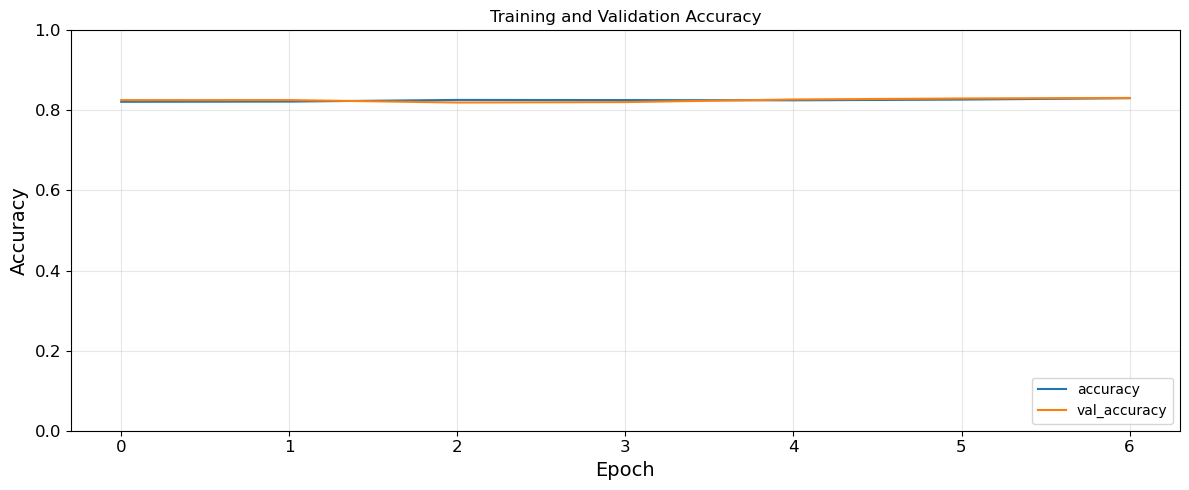

313/313 - 3s - 9ms/step - accuracy: 0.8258 - loss: 0.5185

Test accuracy: 0.8258
Test loss: 0.5185


In [ ]:
 # Create subplots for accuracy and loss
fig, ax1 = plt.subplots(1,1, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.0, 1])
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')
ax1.grid(True, alpha=0.3)

save_fig("phase3_training_history")

plt.tight_layout()
plt.show()


# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

In [ ]:
# =============================================================================
# PHASE 3: Corrected Final Comprehensive Logging
# =============================================================================

# Create Phase 3 file writer
file_writer_phase3 = tf.summary.create_file_writer(log_dir_phase3)
with file_writer_phase3.as_default():
    # Get actual training info
    actual_epochs = len(history.history['loss'])
    final_lr = model.optimizer.learning_rate.numpy()

    # 1. Model architecture
    img_path = f'{log_dir_phase3}/model_architecture.png'
    plot_model(model, to_file=img_path, show_shapes=True, show_layer_names=True)
    image = tf.keras.preprocessing.image.load_img(img_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    tf.summary.image("Model Architecture", [image], step=0)

    # 2. Extract data augmentation parameters (with proper type handling)
    aug_params = {}
    if len(model.layers) > 1 and hasattr(model.layers[1], 'layers'):
        for i, layer in enumerate(model.layers[1].layers):
            layer_name = f"{layer.__class__.__name__}_{i}"
            
            # Handle factor (can be float, int, tuple, or None)
            if hasattr(layer, 'factor'):
                factor = layer.factor
                if factor is None:
                    aug_params[f"{layer_name}_factor"] = None
                elif isinstance(factor, (tuple, list)):
                    aug_params[f"{layer_name}_factor"] = list(factor)  # Convert to list for JSON serialization
                else:
                    aug_params[f"{layer_name}_factor"] = float(factor)
            
            # Handle height_factor (can be float, int, tuple, or None)
            if hasattr(layer, 'height_factor'):
                height_factor = layer.height_factor
                if height_factor is None:
                    aug_params[f"{layer_name}_height_factor"] = None
                elif isinstance(height_factor, (tuple, list)):
                    aug_params[f"{layer_name}_height_factor"] = list(height_factor)
                else:
                    aug_params[f"{layer_name}_height_factor"] = float(height_factor)
            
            # Handle width_factor (can be float, int, tuple, or None)
            if hasattr(layer, 'width_factor'):
                width_factor = layer.width_factor
                if width_factor is None:
                    aug_params[f"{layer_name}_width_factor"] = None
                elif isinstance(width_factor, (tuple, list)):
                    aug_params[f"{layer_name}_width_factor"] = list(width_factor)
                else:
                    aug_params[f"{layer_name}_width_factor"] = float(width_factor)
            
            # Handle string attributes
            if hasattr(layer, 'mode'):
                aug_params[f"{layer_name}_mode"] = str(layer.mode) if layer.mode is not None else None
            if hasattr(layer, 'fill_mode'):
                aug_params[f"{layer_name}_fill_mode"] = str(layer.fill_mode) if layer.fill_mode is not None else None
            if hasattr(layer, 'interpolation'):
                aug_params[f"{layer_name}_interpolation"] = str(layer.interpolation) if layer.interpolation is not None else None
            
            # Handle seed (can be None)
            if hasattr(layer, 'seed'):
                aug_params[f"{layer_name}_seed"] = int(layer.seed) if layer.seed is not None else None
            
            # Always include layer type
            aug_params[f"{layer_name}_type"] = layer.__class__.__name__

    # 3. Calculate performance metrics
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    best_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    best_loss_epoch = history.history['val_loss'].index(best_val_loss) + 1

    # 4. Build augmentation section
    aug_section = ""
    if aug_params:
        aug_lines = [f"    - {k}: {v}" for k, v in aug_params.items()]
        aug_section = f"""
    
    **Data Augmentation:**
{chr(10).join(aug_lines)}"""

    # 5. Get initial learning rate dynamically
    try:
        optimizer_config = model.optimizer.get_config()
        initial_lr = optimizer_config.get('learning_rate', 'Unknown')
    except:
        initial_lr = 'Unknown'
    
    # 6. Build callbacks information (FIX: Create callbacks_section properly)
    callbacks_info = []
    for callback in callbacks:
        if isinstance(callback, tf.keras.callbacks.ReduceLROnPlateau):
            callbacks_info.append(f"    - ReduceLROnPlateau (monitor='{callback.monitor}', factor={callback.factor}, patience={callback.patience}, min_lr={callback.min_lr})")
        elif isinstance(callback, tf.keras.callbacks.EarlyStopping):
            callbacks_info.append(f"    - EarlyStopping (monitor='{callback.monitor}', patience={callback.patience}, restore_best_weights={callback.restore_best_weights})")
        elif isinstance(callback, tf.keras.callbacks.TensorBoard):
            callbacks_info.append(f"    - TensorBoard (log_dir='{callback.log_dir}', histogram_freq={callback.histogram_freq})")
        else:
            callbacks_info.append(f"    - {callback.__class__.__name__}")
    
    # FIX: Convert callbacks_info list to callbacks_section string
    callbacks_section = '\n'.join(callbacks_info) if callbacks_info else "    - No callbacks configured"
    
    # 7. Get batch size and epochs from variables
    batch_size = BATCH_SIZE
    planned_epochs = EPOCHS

    # 8. Build training summary
    training_summary = f"""
    **PHASE 3: Final Training Configuration & Results**
    
    **Model Architecture:**
    - Total Parameters: {model.count_params():,}
    - Total Layers: {len(model.layers)}
    - Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}
    
    **Optimizer:** {model.optimizer.__class__.__name__}
    - Initial Learning Rate: {initial_lr}
    - Final Learning Rate: {final_lr:.2e}
    - Clipnorm: {model.optimizer.clipnorm}
    
    **Loss:** {model.loss}
    **Metrics:** {[m.name for m in model.metrics]}{aug_section}
    
    **Training Details:**
    - Planned Epochs: {planned_epochs}
    - Actual Epochs Run: {actual_epochs}
    - Batch Size: {batch_size}
    - Training Samples: {len(x_train):,}
    - Validation Samples: {len(x_test):,}
    - Steps per Epoch: {len(x_train) // batch_size}
    
    **Final Performance (Epoch {actual_epochs}):**
    - Train Accuracy: {history.history['accuracy'][-1]:.4f}
    - Train Loss: {history.history['loss'][-1]:.4f}
    - Val Accuracy: {history.history['val_accuracy'][-1]:.4f}
    - Val Loss: {history.history['val_loss'][-1]:.4f}
    
    **Best Performance:**
    - Best Val Accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})
    - Best Val Loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})
    
    **Callbacks Used:**
{callbacks_section}
    
    **Training Time:** {timestamp}
    **Log Directory:** {log_dir_phase3}
    """
    tf.summary.text("Complete Training Report", training_summary, step=0)

    # 9. Log key metrics as scalars
    tf.summary.scalar('phase3_final/planned_epochs', planned_epochs, step=0)
    tf.summary.scalar('phase3_final/epochs_trained', actual_epochs, step=0)
    tf.summary.scalar('phase3_final/batch_size', batch_size, step=0)
    tf.summary.scalar('phase3_final/best_val_accuracy', best_val_acc, step=0)
    tf.summary.scalar('phase3_final/best_val_loss', best_val_loss, step=0)
    tf.summary.scalar('phase3_final/final_val_accuracy', history.history['val_accuracy'][-1], step=0)
    tf.summary.scalar('phase3_final/final_learning_rate', final_lr, step=0)
    tf.summary.scalar('phase3_final/total_parameters', model.count_params(), step=0)

    # 10. Log augmentation parameters as scalars (with proper type checking)
    for param, value in aug_params.items():
        if isinstance(value, (int, float)):
            tf.summary.scalar(f'phase3_augmentation/{param}', value, step=0)
        elif isinstance(value, (list, tuple)) and len(value) == 2 and all(isinstance(x, (int, float)) for x in value):
            # For tuple/list parameters like (0.1, 0.2), log min and max separately
            tf.summary.scalar(f'phase3_augmentation/{param}_min', float(value[0]), step=0)
            tf.summary.scalar(f'phase3_augmentation/{param}_max', float(value[1]), step=0)
        elif value is None:
            # Skip None values for scalar logging (can't log None as scalar)
            pass
        # String values are automatically skipped as they can't be logged as scalars

    # 11. Model summary
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    model_summary = "\n".join(stringlist)
    tf.summary.text("Model Architecture Details", model_summary, step=0)

    # 12. Training history graph data
    history_json = json.dumps(history.history, indent=2)
    tf.summary.text("Training History JSON", f"```json\n{history_json}\n```", step=0)

    # 13. Log augmentation parameters as text
    if aug_params:
        tf.summary.text("Data Augmentation Parameters", json.dumps(aug_params, indent=2), step=0)

    # Flush summaries
    file_writer_phase3.flush()

# =============================================================================
# PHASE 3: Final Model and Data Saving
# =============================================================================

print("Phase 3: Saving final model and training artifacts...")

# Save model and weights
model_path = f'{log_dir_phase3}/phase3_final_model.keras'
weights_path = f'{log_dir_phase3}/phase3_final_weights.weights.h5'
history_path = f'{log_dir_phase3}/phase3_training_history.json'

model.save(model_path)
model.save_weights(weights_path)

# Save history
with open(history_path, 'w') as f:
    json.dump(history.history, f, indent=2)

# Save augmentation parameters
if aug_params:
    aug_path = f'{log_dir_phase3}/phase3_augmentation_params.json'
    with open(aug_path, 'w') as f:
        json.dump(aug_params, f, indent=2)
    print(f"✓ Augmentation parameters saved: {aug_path}")

# Create Phase 3 final summary
summary_path = f'{log_dir_phase3}/phase3_final_summary.txt'
with open(summary_path, 'w') as f:
    f.write(f"""
=============================================================================
PHASE 3: FINAL TRAINING RESULTS SUMMARY
=============================================================================

EXPERIMENT COMPLETE - FINAL RESULTS

Training Configuration:
- Batch Size: {batch_size}
- Planned Epochs: {planned_epochs}
- Actual Epochs: {actual_epochs}
- Completion Rate: {(actual_epochs/planned_epochs)*100:.1f}%

Model Information:
- Total Parameters: {model.count_params():,}
- Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}
- Total Layers: {len(model.layers)}

FINAL PERFORMANCE RESULTS:
- Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})
- Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}
- Best Validation Loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})
- Final Validation Loss: {history.history['val_loss'][-1]:.4f}

Performance Gap Analysis:
- Train-Val Accuracy Gap: {(history.history['accuracy'][-1] - history.history['val_accuracy'][-1]):.4f}
- Val-Train Loss Gap: {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}

Files Created:
- Final Model: {model_path}
- Final Weights: {weights_path}  
- Training History: {history_path}
- Summary: {summary_path}

TensorBoard Command:
tensorboard --logdir {log_dir_phase3}

Generated: {timestamp}

STATUS: TRAINING COMPLETE - MODEL READY FOR DEPLOYMENT
=============================================================================
""")

print("\n" + "="*70)
print("PHASE 3: FINAL LOGGING COMPLETED SUCCESSFULLY")
print("="*70)
print("🎯 TRAINING EXPERIMENT COMPLETE 🎯")
print(f"✓ Final model saved: {model_path}")
print(f"✓ Final weights saved: {weights_path}")
print(f"✓ Training history saved: {history_path}")
print(f"✓ Final summary saved: {summary_path}")
print(f"✓ TensorBoard logs: {log_dir_phase3}")
print(f"\n📊 FINAL PERFORMANCE:")
print(f"   Best validation accuracy: {best_val_acc:.4f} (Epoch {best_acc_epoch})")
print(f"   Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"   Training completed: {actual_epochs}/{planned_epochs} epochs ({(actual_epochs/planned_epochs)*100:.1f}%)")
print(f"\n🚀 View results: tensorboard --logdir {log_dir_phase3}")
print("="*70)
print("MODEL READY FOR INFERENCE/DEPLOYMENT")
print("="*70)

Phase 3: Saving final model and training artifacts...

PHASE 3: FINAL LOGGING COMPLETED SUCCESSFULLY
🎯 TRAINING EXPERIMENT COMPLETE 🎯
✓ Final model saved: logs/fit/train_20250831-200638/phase3/phase3_final_model.keras
✓ Final weights saved: logs/fit/train_20250831-200638/phase3/phase3_final_weights.weights.h5
✓ Training history saved: logs/fit/train_20250831-200638/phase3/phase3_training_history.json
✓ Final summary saved: logs/fit/train_20250831-200638/phase3/phase3_final_summary.txt
✓ TensorBoard logs: logs/fit/train_20250831-200638/phase3

📊 FINAL PERFORMANCE:
   Best validation accuracy: 0.8312 (Epoch 7)
   Final validation accuracy: 0.8312
   Training completed: 7/100 epochs (7.0%)

🚀 View results: tensorboard --logdir logs/fit/train_20250831-200638/phase3
MODEL READY FOR INFERENCE/DEPLOYMENT
